# 1. Problem

**Use GANs to create art - will you be the next Monet?**

In this project, we will build and train a GAN that generates images in the style of Monet. The generator is trained using a discriminator and the task is to build a generator that generates 7000 to 10000 Monet-style images.

Generative Adversarial Networks (GANs) are a class of machine learning frameworks where two neural networks, a generator and a discriminator, compete in a zero-sum game.
The generator learns to create realistic data, while the discriminator learns to distinguish between real and fake data. 
This adversarial training process pushes both networks to improve until the generator produces high-quality, synthetic data that is nearly indistinguishable from real data.


## About the Dataset

The dataset contains four directories: `monet_tfrec`, `photo_tfrec`, `monet_jpg`, and `photo_jpg`. The `monet_tfrec` and `monet_jpg` directories contain the same painting images, and the `photo_tfre`c and `photo_jpg` directories contain the same photos.

The `monet` directories contain Monet paintings, which we will use to train our model. The `photo` directories contain photos, and we will add Monet-style to these images.

We will submit our generated jpeg images as a zip file.

## Import Libraries

In [51]:
! pip install -q kaggle
! pip install opencv-python
! pip install pandas

! pip install matplotlib tensorflow
! pip install -U scikit-learn
! pip install -U keras

Python(79446) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


DEPRECATION: Loading egg at /opt/homebrew/lib/python3.11/site-packages/api-0.0.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


Python(79498) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


DEPRECATION: Loading egg at /opt/homebrew/lib/python3.11/site-packages/api-0.0.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


Python(79518) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


DEPRECATION: Loading egg at /opt/homebrew/lib/python3.11/site-packages/api-0.0.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


Python(79566) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


DEPRECATION: Loading egg at /opt/homebrew/lib/python3.11/site-packages/api-0.0.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3


Python(79632) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


DEPRECATION: Loading egg at /opt/homebrew/lib/python3.11/site-packages/api-0.0.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


Python(79699) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


DEPRECATION: Loading egg at /opt/homebrew/lib/python3.11/site-packages/api-0.0.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Using cached keras-3.3.3-py3-none-any.whl.metadata (5.7 kB)
Using cached keras-3.3.3-py3-none-any.whl (1.1 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.1 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [52]:
import cv2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import shutil
import zipfile

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2DTranspose, Conv2D, BatchNormalization, LeakyReLU, Reshape, Dense, Flatten, Dropout, UpSampling2D

## Load dataset

Visit [here](https://www.kaggle.com/discussions/general/74235) to learn how to download data from Kaggle to google colab

In [53]:
# from google.colab import drive # uncomment if you're using google colab
# drive.mount('/content/drive')

In [54]:
# upload kaggle credentials # uncomment if you're using google colab
# uploaded = files.upload()

In [55]:
# ! mkdir ./.kaggle

In [56]:
# copy kaggle.json to .kaggle # update kaggle.json path to path to kaggle.json
# ! cp ~/Desktop/MSCS/kaggle/kaggle.json ./.kaggle/

In [57]:
# change permissions of the file
# ! chmod 600 ./.kaggle/kaggle.json

In [58]:
# check if everything works well
# ! kaggle datasets list

In [59]:
# download dataset
# ! kaggle competitions download -c gan-getting-started

In [60]:
# ! mkdir gan-images

In [61]:
# unzip data
# ! unzip gan-getting-started.zip -d gan-images

In [62]:
monet_images_jpg_folder = "gan-images/monet_jpg"
monet_images_tfrec_folder = "gan-images/monet_tfrec"
test_images_jpg_folder = "gan-images/photo_jpg"
test_images_tfrec_folder = "gan-images/photo_tfrec"

# 2. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

### Image Preprocessing

In [63]:
def preprocess_image(image_path, target_size=(256, 256)):
    """Preprocess a Monet painting image."""
    # Load image
    img = cv2.imread(image_path)

    # Normalize
    # normalized_pixel = (original_pixel / 127.5) - 1
    # RGB pixels range 0 - 255
    # divide by 127.5 to shift range center from 127.5 to 0
    # minus 1 to scale to range between -1 to 1
    normalized_img = (img.astype(np.float32) / 127.5) - 1  

    return normalized_img

def load_images_from_folder(folder):
    images = []
    image_filenames = []
    image_labels = []
    for filename in os.listdir(folder):
        if filename.endswith('.jpg'):
            file_path = os.path.join(folder, filename)
            img = preprocess_image(file_path)

            if img is not None:
                images.append(img)
                image_filenames.append(file_path)
                label = os.path.splitext(filename)[0]
                image_labels.append(label)
    return images, image_filenames, image_labels


monet_jpgs, monet_filenames, monet_labels = load_images_from_folder(monet_images_jpg_folder)
# monet_tfrec = load_images_from_folder(monet_images_tfrec_folder)
test_jpgs, test_filenames, test_labels = load_images_from_folder(test_images_jpg_folder)
# test_tfrec = load_images_from_folder(test_images_tfrec_folder)


In [64]:
def show_images(images: list, labels: list, num=5):
    fig = plt.figure(figsize=(25, 4))
    for i in range(num):
        ax = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
        im = images[i]
        plt.imshow(im)
        label = labels[i]
        ax.set_title(f'#{i+1} - Label: {label}')

**monet jpg samples**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


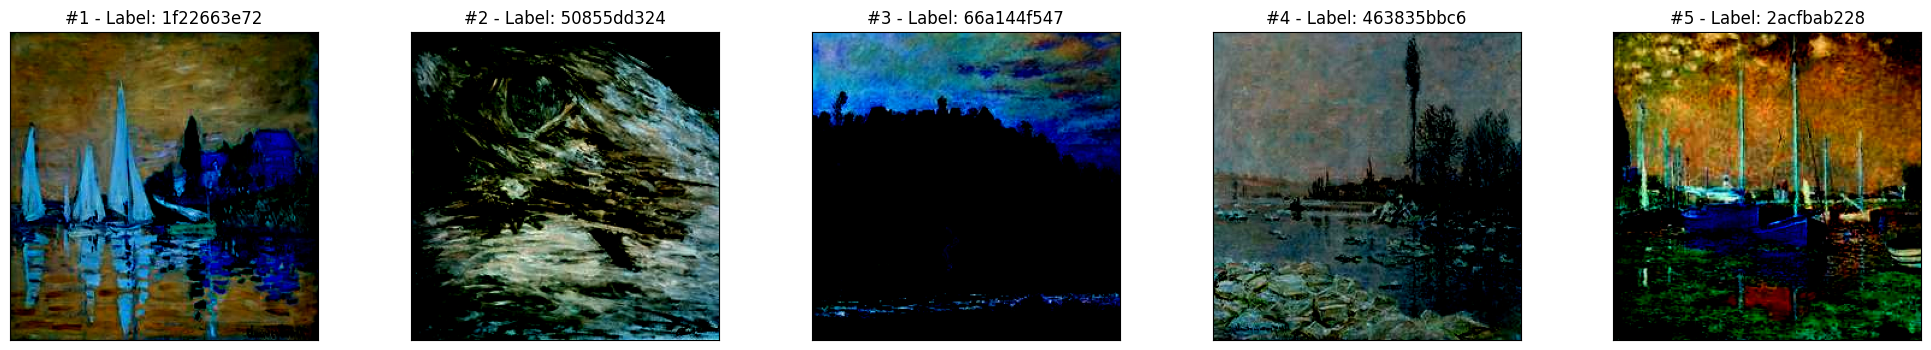

In [65]:
show_images(monet_jpgs, monet_labels)

**Test jpg samples**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


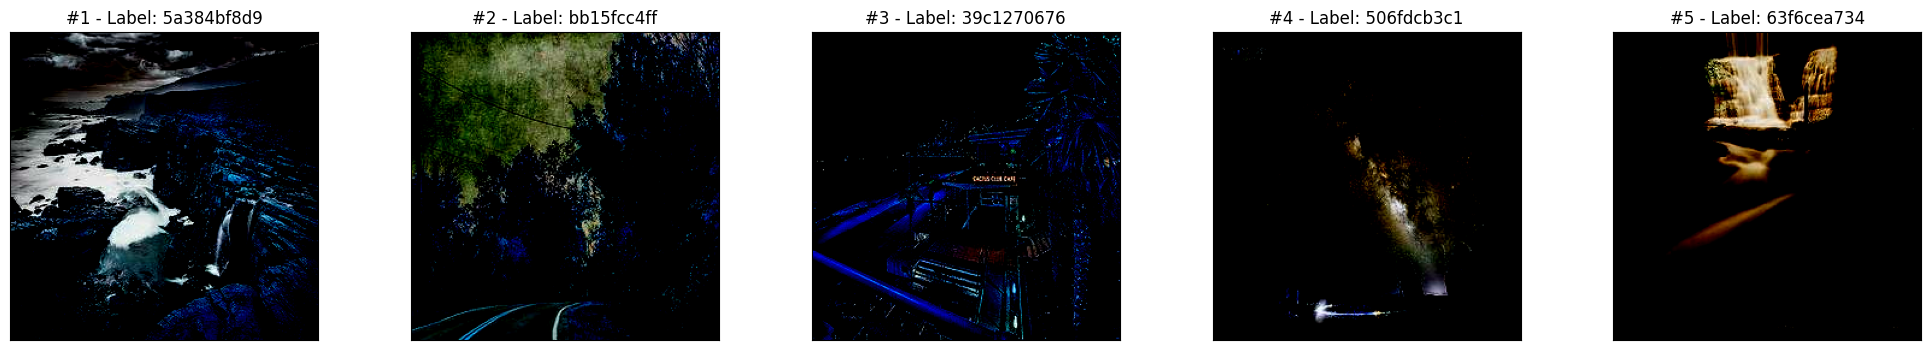

In [66]:
show_images(test_jpgs, test_labels)

**create images dataframe**

In [67]:
df = pd.DataFrame({ "filename": monet_labels, "label": monet_labels })
df['filename'] += '.jpg'
df.head(5)

,filename,label
0,1f22663e72.jpg,1f22663e72
1,50855dd324.jpg,50855dd324
2,66a144f547.jpg,66a144f547
3,463835bbc6.jpg,463835bbc6
4,2acfbab228.jpg,2acfbab228


**Split the data**

In [68]:
train_df, validation_df = train_test_split(df, test_size=0.2, random_state=42)

In [69]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240 entries, 232 to 102
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  240 non-null    object
 1   label     240 non-null    object
dtypes: object(2)
memory usage: 5.6+ KB


In [70]:
validation_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, 203 to 25
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  60 non-null     object
 1   label     60 non-null     object
dtypes: object(2)
memory usage: 1.4+ KB


### Batch and Shuffle data

In [71]:
BUFFER_SIZE = 1000
BATCH_SIZE = 32

train_dataset = tf.data.Dataset.from_tensor_slices(monet_jpgs).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 3. GAN Model & Analysis

In [72]:
# zip output images
def zip_images_output(directory):
    # Creating the ZIP file 
    archived = shutil.make_archive(directory, 'zip', directory)
    if os.path.exists(f'{directory}.zip'):
        print(archived) 
    else: 
        print("ZIP file not created")

**The Generator**

- The generator model starts with **random noise (numbers)** and gradually transforms it into a realistic image.
- The **Dense layer** provides the initial structure, like a rough sketch.
- The **Reshape layer** prepares the "canvas."
- **Conv2DTranspose layers** add details at different scales, like painting with different brushes.
- **BatchNormalization** adjusts colors for better quality.
- **LeakyReLU** and **tanh functions** make the colors more vivid and realistic.

**The Discriminator**

- The discriminator starts with the **input layer** of `shape=(256, 256, 3)` image size
- The **Conv2D Layers** for feature extractions
- **LeakyReLU Activation** allows a small gradient for negative values, preventing neurons from getting stuck and not learning.
- **Dropout layer** acts as a regularization technique to prevent overfitting. It randomly drops out (disables) neurons during training, forcing the network to learn more robust features.
- **Flatten layer** flattens the 3D output of the convolutional layers into a 1D vector to be used as input for the fully connected layers
- **BatchNormaliztion** to improve training stability and speed


In [73]:
def build_generator_model(latent_dim=100):
    model = Sequential()
    model.add(Dense(8 * 8 * 256, input_shape=(latent_dim,)))  # Project noise to 8x8x256
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8, 8, 256)))                     # Reshape to 8x8 feature maps

    model.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    model.add(UpSampling2D())  
    return model


def build_discriminator_model(img_shape=(256, 256, 3)):
    model = Sequential()
    model.add(Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=img_shape))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))  # Add some dropout for regularization

    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model


**Test generator and discriminator**

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


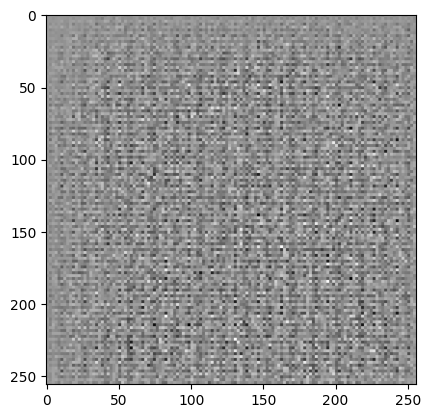

In [74]:
generator = build_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [75]:
discriminator = build_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.49997845]], shape=(1, 1), dtype=float32)


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Model Training

#### Mirrored Strategy

We are going to use Tensorflow distribution strategy to distribute training across multiple GPUs, or TPUs.

In [76]:
mirrored_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


#### Loss functions

**discriminator_loss**

The **discriminator_loss** guides the discriminator's learning process. it checks how close the discriminator's prediction (`real_output`) on a batch of real images
is to 1. The closer to 1 the higher the confidence that they are real i.e real images should be close to 1.

It also checks how close the discriminator's prediction (`fake_output`) on a batch of fake images is to 0. The closer to 0 the higher the confidence that they are fake.

Since the discriminator's role is to identify real and fake images, the higher the `total_loss` the better it's performance. This will force the generator to try to generate more images
that will beat the discriminator.

**generator_loss**

The role of the generator is to generate images (fake images) that are as close to the real images as possible, so it can fool the discriminator. Hence, the **generator_loss** checks how close the discriminator's prediction (`fake_output`) is to 1 (real_images).


In [77]:
# loss function
with mirrored_strategy.scope():
    def discriminator_loss(real_output, fake_output):
        cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss

        return total_loss

    def generator_loss(fake_output):
        cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        return cross_entropy(tf.ones_like(fake_output), fake_output)

#### Generator, Discriminator, and Optimizers
We will build our generator and discriminator and use the Adam optimizaition for our model. We will add them all to the `mirrored_stategy.scope`.

In [78]:
with mirrored_strategy.scope():
    generator = build_generator_model()
    discriminator = build_discriminator_model()
    #optimizers
    generator_optimizer = tf.keras.optimizers.Adam(0.0001)
    discriminator_optimizer = tf.keras.optimizers.Adam(0.0001)

#### DCGAN Model

In [79]:
class DCGAN_model:
    def __init__(self, noise_dim, seed, epochs, batch_size, generator, discriminator, dataset, num_examples_to_generate=25, checkpoint_dir='./training_checkpoints') -> None:
        self.noise_dim = noise_dim
        self.EPOCHS = epochs
        self.BATCH_SIZE = batch_size
        self.generator = generator
        self.discriminator = discriminator
        self.dataset = dataset
        # self.num = num_model
        self.seed = seed
        self.num_examples_to_generate = num_examples_to_generate
        self.checkpoint_dir = checkpoint_dir
        self.checkpoint = None
        self.get_checkpoint(checkpoint_dir)

    def generate_images(self, seed, training=True):
        return self.generator(seed, training=training)

    def save_images(self, images, epoch, directory='./grid-images'):
        gen_imgs = 0.5 * images + 0.5

        fig = plt.figure(figsize=(5, 5))

        for i in range(self.num_examples_to_generate):
            plt.subplot(5, 5, i+1)
            plt.imshow(gen_imgs[i, :, :, :])
            plt.axis('off')

        plt.savefig(os.path.join(directory, 'image_at_epoch_{:04d}.png'.format(epoch)))
        plt.close()

    def save_single_images(self, images, epoch, directory='./images'):
        gen_imgs = 0.5 * images + 0.5
        for i in range(self.num_examples_to_generate):
            image = gen_imgs[i]
            image_np = image.numpy()
            img = (image_np * 255).astype(np.uint8)
            cv2.imwrite(os.path.join(directory, f"image_{i}_at_{epoch}.jpg"), img)
    
    def write_images_to_zip(self, images, zip_filename, augument_images=False):
        """
        Writes images from a tf.data.Dataset directly into a zip file using OpenCV.
        """
        with zipfile.ZipFile(f"{zip_filename}", 'w', zipfile.ZIP_DEFLATED) as zipf:
            counter = 0
            gen_imgs = images

            if augument_images:
                gen_imgs = 0.5 * images + 0.5
            for image in gen_imgs:
                image_np = image.numpy()
                # denormalize
                img = (image_np * 255).astype(np.uint8) 
                img = cv2.resize(img, (256, 256))
                # Encode image to JPEG in memory
                _, img_encoded = cv2.imencode('.jpg', img)
                # Write to zip file
                zipf.writestr(f'image_{counter}_.jpg', img_encoded.tobytes())
                counter+=1

    def plot_images(self, images):      
            gen_imgs = 0.5 * images + 0.5
            
            fig = plt.figure(figsize=(10, 10))
            for i in range(self.num_examples_to_generate):
                plt.subplot(5, 5, i+1)
                plt.imshow(gen_imgs[i, :, :, :])
                plt.axis('off')
            plt.show()

    def show_images(self, images: list):
        gen_imgs = 0.5 * images + 0.5

        fig = plt.figure(figsize=(5, 5))

        for i in range(self.num_examples_to_generate):
            plt.subplot(5, 5, i+1)
            plt.imshow(gen_imgs[i, :, :, :])
            plt.axis('off')
        plt.show()
    
    def get_checkpoint(self, checkpoint_dir):
        # This will enable us to restore models, which can be helpful incase a long running training task is interrupted
        if self.checkpoint is None:
            self.checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
            self.checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                            discriminator_optimizer=discriminator_optimizer,
                                            generator=self.generator,
                                            discriminator=self.discriminator)
        return self.checkpoint


    @tf.function
    def train(self, images):
        # # generate random noise
        noise = tf.random.normal([images.shape[0], self.noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # generate fake images from noise
            generated_images = self.generator(noise, training=True)

            # discriminate both real and fake images
            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            # compute loss
            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

            # compute gradient
            gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

            # update optimizers
            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    @tf.function
    def distributed_train(self, images):
        per_replica_losses = mirrored_strategy.run(self.train, args=(images,))
        return mirrored_strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses, axis=None)
    
    def train_loop(self, output_folder, write_output_to_file=False, save_after_epoch=20):
        for epoch in range(self.EPOCHS):
            start = time.time()

            for image_batch in self.dataset:
                self.distributed_train(image_batch)

            if write_output_to_file:
#                 generated_images = self.generate_images(training=False)
#                 self.save_images(generated_images, epoch + 1, directory=f"./{output_folder}-grid")

                # save images at the end of epochs
                if epoch+1 == self.EPOCHS:
                    generated_images = self.generate_images(seed=self.seed, training=False)
                    self.write_images_to_zip(generated_images, zip_filename=f"{output_folder}.zip")

            # Save the checkpoint and show images at specified epoch interval
            if (epoch + 1) % save_after_epoch == 0:
                self.checkpoint.save(file_prefix = self.checkpoint_prefix)
                generated_images = self.generate_images(seed=self.seed, training=False)
                self.show_images(generated_images)
            print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


#### Training

In [81]:
# make directory for generated images; see OUTPUT_FOLDER VALUE
! mkdir train-images-grid # epoch output
! mkdir train-images # single image output

mkdir: train-images-grid: File exists
mkdir: train-images: File exists


Python(80522) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(80531) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


/opt/homebrew/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:674: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Time for epoch 1 is 13.22903299331665 sec
Time for epoch 2 is 10.298282861709595 sec
Time for epoch 3 is 9.813426971435547 sec
Time for epoch 4 is 9.59727692604065 sec


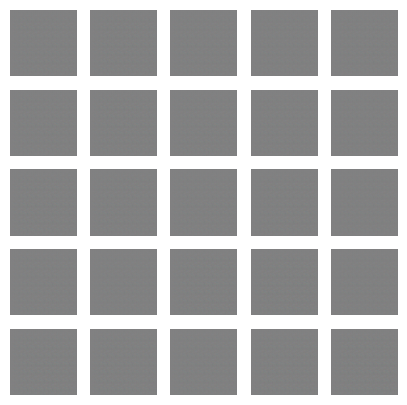

Time for epoch 5 is 9.91361403465271 sec
Time for epoch 6 is 9.74618411064148 sec
Time for epoch 7 is 9.163118124008179 sec
Time for epoch 8 is 9.252907037734985 sec
Time for epoch 9 is 9.84997010231018 sec


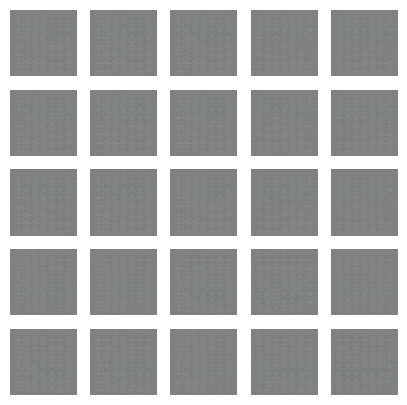

Time for epoch 10 is 9.895117044448853 sec


In [82]:
# Hyperparameters
EPOCHS = 10
BATCH_SIZE = 32
noise_dim = 100
shape_dim = [256,256,3]
num_examples_to_generate = 25
seed = tf.random.normal([num_examples_to_generate, noise_dim])
OUTPUT_FOLDER = 'train-images'

# create model and train
tf.keras.backend.clear_session(
    free_memory=True
)
gan_model = DCGAN_model(noise_dim=noise_dim, seed=seed, epochs=EPOCHS, batch_size=BATCH_SIZE, generator=generator, discriminator=discriminator, dataset=train_dataset)
gan_model.train_loop(output_folder=OUTPUT_FOLDER, write_output_to_file=False, save_after_epoch=5)

### Model Testing

In [83]:
num_examples_to_generate = 700
test_noise = tf.random.normal([num_examples_to_generate, noise_dim])
OUTPUT_FOLDER = './images'

model_pred_images = gan_model.generate_images(seed=test_noise, training=False)
gan_model.write_images_to_zip(model_pred_images, zip_filename=f"{OUTPUT_FOLDER}.zip")


# 4. Conclusion

The project involved training a Deep Convolutional Generative Adversarial Network (DCGAN) model to generate Monet paintings.
We applied some preprocessing to our train dataset and then developed our generator and discriminator model, working hand-in-hand to ensure the generator can produce real enough paintings.

The model is quite resource and time consuming, hence, we couldn't train the model for long enough.
However, we were still able to generate some promising images that indicates that further training time and resource would lead to much improved generated images.


In future experiments, I'd ensure there is enough computer resources to train our models properly.